In [1]:
import shutil
import os
from PIL import Image
from random import sample
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
import re
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import BCELoss
from sklearn.metrics import classification_report, accuracy_score, auc
from tqdm.notebook import tqdm
from yacs.config import CfgNode as CN
from datetime import datetime
from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision.models import mobilenet_v3_large

In [2]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

In [3]:
_C = CN()

_C.ROOT_PATH = "../data"
_C.TRAIN_PATH = os.path.join(_C.ROOT_PATH, 'train')
_C.VAL_PATH = os.path.join(_C.ROOT_PATH, 'test')
_C.VAL_PATH_MIXED = os.path.join(_C.ROOT_PATH, 'test_mixed')
_C.CLASSES = ['blur', 'demoir', 'haze', 'rain']
_C.BATCH_SIZE = 4

#values for preprocessing
_C.IMAGE_W = 512
_C.IMAGE_H = 512
_C.MEAN = [0.4649, 0.4426, 0.4149]
_C.VAR = [0.2830, 0.2772, 0.2891]

In [4]:
print(os.listdir(_C.TRAIN_PATH))
print(len(os.listdir(_C.TRAIN_PATH)))

['blur', 'demoir', 'demoir_blur', 'haze', 'rain', 'rain_blur']
6


In [16]:
print(os.listdir(_C.VAL_PATH))
print(len(os.listdir(_C.VAL_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


decoding encoding labels

In [6]:
def encode_label(label, classes_list = _C.CLASSES): #encoding the classes into a tensor of shape (4) with 0s and 1s.
    target = torch.zeros(len(classes_list))
    for l in label:
      if l in classes_list:
          idx = classes_list.index(l)
          target[idx] = 1
    return target

def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(_C.CLASSES[i])
    if len(result) == 0:
        return "clear"
    else:
        return ' '.join(result)

A class creating dataset from a folder with different types of images, separated by types of degradation, applied to a picture.

In [7]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)              

    def __len__(self):
        return len(self.images)       
    def im_path(self, idx):
        return self.images[idx]
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img) 
        
        label = img_path.split('/')[3].split('_')
        if 'clear_gt' in img_path:
            encoded_label = torch.Tensor([0,0,0,0])
        else:
            encoded_label = encode_label(label)
        
        return img, encoded_label, encode_label(label)

A function, that lists all images contained in the folder.

In [8]:
#Making a list that contains the paths of each image
def get_path_names(folder):
  images = []
  for path, subdirs, files in os.walk(folder):  
    for name in files: 
      images.append(os.path.join(path, name))
  return images

defining transforms for training and validation dataset

In [9]:
#setting a set of transformations to transform the images 
train_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor()])
val_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                       T.ToTensor()])

In [10]:
train_dataset = myDataset(_C.TRAIN_PATH, transform = train_trans)
val_dataset = myDataset(_C.VAL_PATH, transform = val_trans)
print(len(train_dataset))
print(len(val_dataset))

38299
7629


Label: clear
mask: blur

tensor([0., 0., 0., 0.])
../data/train/blur/clear_gt/real_blur/gt_197.png


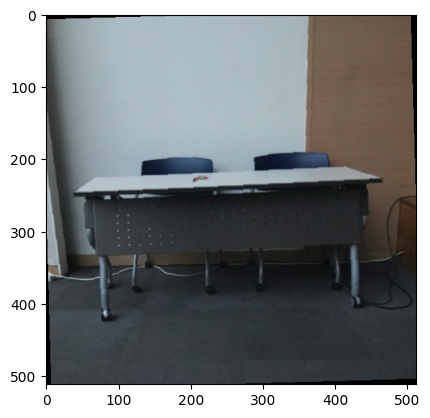

In [11]:
def show_example(img, label, mask):
  plt.imshow(img.permute(1,2,0))
  print("Label:", decode_target(label))
  print("mask:", decode_target(mask))
  print()
  print(label)

show_example(*train_dataset[5000])
print(train_dataset.im_path(5000))

Label: clear
mask: demoir

tensor([0., 0., 0., 0.])


'../data/test/demoir/clear_gt/image_374.jpg'

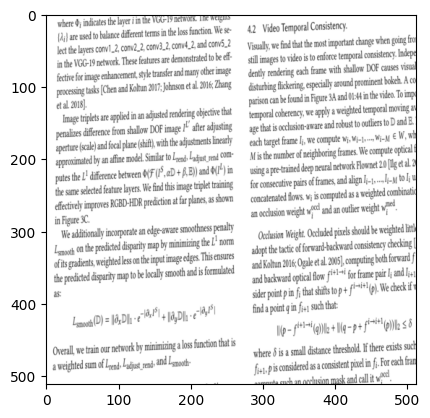

In [12]:
show_example(*val_dataset[3350])
val_dataset.im_path(3350)

In [13]:
train_loader = DataLoader(train_dataset, _C.BATCH_SIZE, shuffle=True, num_workers = 12)
val_loader = DataLoader(val_dataset, _C.BATCH_SIZE * 2, num_workers = 12)

In [14]:
# placeholders
#psum    = torch.tensor([0.0, 0.0, 0.0])
#psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
#for inputs, mask, target in tqdm(train_loader):
#    psum    += inputs.sum(axis        = [0, 2, 3])
#    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

In [15]:
# pixel count
#count = len(train_dataset) * _C.IMAGE_H * _C.IMAGE_W

# mean and std
#total_mean = psum / count
#total_var  = (psum_sq / count) - (total_mean ** 2)
#total_std  = torch.sqrt(total_var)

# output
#print('mean: '  + str(total_mean))
#print('std:  '  + str(total_std))

In [16]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

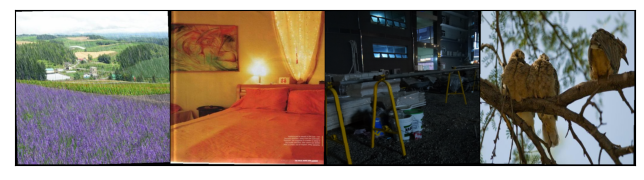

In [17]:
def show_batch(dl, nmax=16):
    for images, labels, masks in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:nmax], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [18]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [19]:
def F_scores(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    precision, recall, F2 = [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    for i in range(4):
        precision.append(torch.mean(TP[i] / (TP[i] + FP[i] + 1e-12)))
        recall.append(torch.mean(TP[i] / (TP[i] + FN[i] + 1e-12)))
        F2_sus = (1 + beta**2) * precision[i] * recall[i] / (beta**2 * precision[i] + recall[i] + 1e-12)
        F2.append(F2_sus.mean())
    return F2

In [20]:
def TFPN(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    return TP, TN, FP, FN
def calc_metrics(TP, TN, FP, FN, beta=1):
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return precision, recall, F2

In [21]:
images, targets, masks = next(iter(val_loader))
preds = torch.Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
TP, TN, FP, FN = TFPN(preds, targets)
print(calc_metrics(TP[0], TN[0], FP[0], FN[0]))

(tensor(1.), tensor(0.7500), tensor(0.8571))


In [22]:
def BCE_custom(preds, targets, masks):
    losses = F.binary_cross_entropy(preds, targets, reduction='none')
    for i, mask in enumerate(masks):
        for j, val in enumerate(mask):
            if val == 0:
                losses[i][j] == 0
    return losses.mean()

In [23]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets, masks = batch 
        out = self(images)                            # Generate predictions
        loss = BCE_custom(out, targets, masks)   # Calculate loss
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return loss    
        
    @torch.inference_mode()
    def validation_step(self, batch):
        images, targets, masks = batch
        out = self(images)                           # Generate predictions
        loss = BCE_custom(out, targets, masks)              # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        indiv_scores = F_scores(out, targets)
        TP, TN, FP, FN = TFPN(out, targets)
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return {'val_loss': loss.detach(), 
                'val_score': score.detach(), 
                'val_score_blur': indiv_scores[0].detach(), 
                'val_score_demoir': indiv_scores[1].detach(), 
                'val_score_haze': indiv_scores[2].detach(), 
                'val_score_rain': indiv_scores[3].detach(),
                'TP_blur': TP[0].detach(),
                'TP_demoir': TP[1].detach(),
                'TP_haze': TP[2].detach(),
                'TP_rain': TP[3].detach(),
                'FP_blur': FP[0].detach(),
                'FP_demoir': FP[1].detach(),
                'FP_haze': FP[2].detach(),
                'FP_rain': FP[3].detach(),
                'TN_blur': TN[0].detach(),
                'TN_demoir': TN[1].detach(),
                'TN_haze': TN[2].detach(),
                'TN_rain': TN[3].detach(),
                'FN_blur': FN[0].detach(),
                'FN_demoir': FN[1].detach(),
                'FN_haze': FN[2].detach(),
                'FN_rain': FN[3].detach()} 
    

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        batch_scores_blur = [x['val_score_blur'] for x in outputs]    
        epoch_score_blur = torch.stack(batch_scores_blur).mean()      # exclusive for blur
        batch_scores_demoir = [x['val_score_demoir'] for x in outputs]    
        epoch_score_demoir = torch.stack(batch_scores_demoir).mean()      # exclusive for moire
        batch_scores_haze = [x['val_score_haze'] for x in outputs]    
        epoch_score_haze = torch.stack(batch_scores_haze).mean()      # exclusive for haze
        batch_scores_rain = [x['val_score_rain'] for x in outputs]    
        epoch_score_rain = torch.stack(batch_scores_rain).mean()      # exclusive for rain
        
        TP_blur = float(sum([x['TP_blur'] for x in outputs]))
        FP_blur = float(sum([x['FP_blur'] for x in outputs]))
        TN_blur = float(sum([x['TN_blur'] for x in outputs]))
        FN_blur = float(sum([x['FN_blur'] for x in outputs]))
        
        TP_demoir = float(sum([x['TP_demoir'] for x in outputs]))
        FP_demoir = float(sum([x['FP_demoir'] for x in outputs]))
        TN_demoir = float(sum([x['TN_demoir'] for x in outputs]))
        FN_demoir = float(sum([x['FN_demoir'] for x in outputs]))
        
        TP_haze = float(sum([x['TP_haze'] for x in outputs]))
        FP_haze = float(sum([x['FP_haze'] for x in outputs]))
        TN_haze = float(sum([x['TN_haze'] for x in outputs]))
        FN_haze = float(sum([x['FN_haze'] for x in outputs]))
        
        TP_rain = float(sum([x['TP_rain'] for x in outputs]))
        FP_rain = float(sum([x['FP_rain'] for x in outputs]))
        TN_rain = float(sum([x['TN_rain'] for x in outputs]))
        FN_rain = float(sum([x['FN_rain'] for x in outputs]))
        
        TP_total = TP_blur + TP_haze + TP_demoir + TP_rain
        FP_total = FP_blur + FP_haze + FP_demoir + FP_rain
        TN_total = TN_blur + TN_haze + TN_demoir + TN_rain
        FN_total = FN_blur + FN_haze + FN_demoir + FN_rain
        
        prec_blur, rec_blur, f2_blur = calc_metrics(TP_blur, TN_blur, FP_blur, FN_blur)
        prec_demoir, rec_demoir, f2_demoir = calc_metrics(TP_demoir, TN_demoir, FP_demoir, FN_demoir)
        prec_haze, rec_haze, f2_haze = calc_metrics(TP_haze, TN_haze, FP_haze, FN_haze)
        prec_rain, rec_rain, f2_rain = calc_metrics(TP_rain, TN_rain, FP_rain, FN_rain)
        prec_total, rec_total, f2_total = calc_metrics(TP_total, TN_total, FP_total, FN_total)
        
        print("blur")
        print(f'prec {prec_blur}, rec {rec_blur}, f2 {f2_blur}')
        print("demoir")
        print(f'prec {prec_demoir}, rec {rec_demoir}, f2 {f2_demoir}')
        print("haze")
        print(f'prec {prec_haze}, rec {rec_haze}, f2 {f2_haze}')
        print("rain")
        print(f'prec {prec_rain}, rec {rec_rain}, f2 {f2_rain}')
        return {'val_loss': epoch_loss.item(), 
                'val_score': f2_total, 
                'val_score_blur': f2_blur, 
                'val_score_haze': f2_haze, 
                'val_score_rain': f2_rain, 
                'val_score_demoir': f2_demoir}    

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}, val_score_blur: {:.4f}, val_score_demoir: {:.4f}, val_score_haze: {:.4f}, val_score_rain: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score'], result['val_score_blur'], result['val_score_demoir'], result['val_score_haze'], result['val_score_rain']))

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')  


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [25]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [26]:
# checking up the shapes of the datas
for xb, yb, masks in train_dl:
  print(xb.shape)
  print(masks.shape)
  print(yb.shape)
  del xb
  del yb
  torch.cuda.empty_cache()
  break

torch.Size([4, 3, 512, 512])
torch.Size([4, 4])
torch.Size([4, 4])


In [27]:
from tqdm.notebook import tqdm

def save_model(model):
    PATH = os.path.join('saved_models', datetime.now().strftime('%d-%m-%y-%H_%M_dqnweights.pt'))
    torch.save(model.state_dict(), PATH)

def load_model(path):
    loaded_model = CustomModel().to(device)
    loaded_model.load_state_dict(torch.load('saved_models/08-05-23-02_49_dqnweights.pt'))
    loaded_model.eval()
    return loaded_model

@torch.inference_mode()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Model number 2: Mobilenet v2 from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

In [28]:
from einops import rearrange


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))
    
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class MV2Block(nn.Module):
    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)
    
    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x


class MobileViT(MultilabelImageClassificationBase):
    def __init__(self, image_size, dims, channels, num_classes, expansion=4, kernel_size=3, patch_size=(2, 2)):
        super().__init__()
        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        L = [2, 4, 3]

        self.conv1 = conv_nxn_bn(3, channels[0], stride=2)

        self.mv2 = nn.ModuleList([])
        self.mv2.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.mv2.append(MV2Block(channels[1], channels[2], 2, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))   # Repeat
        self.mv2.append(MV2Block(channels[3], channels[4], 2, expansion))
        self.mv2.append(MV2Block(channels[5], channels[6], 2, expansion))
        self.mv2.append(MV2Block(channels[7], channels[8], 2, expansion))
        
        self.mvit = nn.ModuleList([])
        self.mvit.append(MobileViTBlock(dims[0], L[0], channels[5], kernel_size, patch_size, int(dims[0]*2)))
        self.mvit.append(MobileViTBlock(dims[1], L[1], channels[7], kernel_size, patch_size, int(dims[1]*4)))
        self.mvit.append(MobileViTBlock(dims[2], L[2], channels[9], kernel_size, patch_size, int(dims[2]*4)))

        self.conv2 = conv_1x1_bn(channels[-2], channels[-1])

        self.pool = nn.AvgPool2d(ih//32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mv2[0](x)

        x = self.mv2[1](x)
        x = self.mv2[2](x)
        x = self.mv2[3](x)      # Repeat

        x = self.mv2[4](x)
        x = self.mvit[0](x)

        x = self.mv2[5](x)
        x = self.mvit[1](x)

        x = self.mv2[6](x)
        x = self.mvit[2](x)
        x = self.conv2(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x


def mobilevit_xxs():
    dims = [64, 80, 96]
    channels = [16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 320]
    return MobileViT((_C.IMAGE_W, _C.IMAGE_H), dims, channels, num_classes=4, expansion=2)


def mobilevit_xs():
    dims = [96, 120, 144]
    channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384]
    return MobileViT((_C.IMAGE_W, _C.IMAGE_H), dims, channels, num_classes=4)


def mobilevit_s():
    dims = [144, 192, 240]
    channels = [16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 640]
    return MobileViT((_C.IMAGE_W, _C.IMAGE_H), dims, channels, num_classes=4)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [29]:
model = mobilevit_s().to(device)
count_parameters(model)

4999280

In [30]:
#checking the shape of outputs that the model will produce before starting the training process
for images, masks, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    del images
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
del outputs

torch.Size([4, 3, 512, 512])
outputs.shape :  torch.Size([4, 4])
Sample outputs :
 tensor([[0.4682, 0.5069, 0.4807, 0.5261],
        [0.4150, 0.4536, 0.4526, 0.5532]], device='cuda:0')


In [31]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(3477078016, 20104192)

In [32]:
epochs = 10
max_lr = 0.001
grad_clip = 0.8
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = [evaluate(model, val_dl)]
history

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.12976799056232793, rec 0.999999999999999, f2 0.22972502610491316
demoir
prec 0.1310787783457858, rec 0.999999999999999, f2 0.23177656738883198
haze
prec 0.0, rec 0.0, f2 0.0
rain
prec 0.13409359024773887, rec 0.999999999999999, f2 0.2364771151176832


[{'val_loss': 0.6937338709831238,
  'val_score': 0.22236162361597356,
  'val_score_blur': 0.22972502610491316,
  'val_score_haze': 0.0,
  'val_score_rain': 0.2364771151176832,
  'val_score_demoir': 0.23177656738883198}]

In [34]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.6234979973297726, rec 0.9434343434343424, f2 0.7508038585204205
demoir
prec 0.967153284671531, rec 0.5299999999999995, f2 0.684754521963366
haze
prec 0.9511343804537514, rec 0.9083333333333327, f2 0.9292412617215796
rain
prec 0.8205128205128195, rec 0.6256109481915927, f2 0.7099278979473729
Epoch [0], last_lr: 0.0003, train_loss: 0.2163, val_loss: 0.1656, val_score: 0.7805, val_score_blur: 0.7508, val_score_demoir: 0.6848, val_score_haze: 0.9292, val_score_rain: 0.7099


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8362445414847153, rec 0.773737373737373, f2 0.8037775445955124
demoir
prec 0.9925149700598788, rec 0.6629999999999994, f2 0.7949640287764973
haze
prec 0.7421150278293132, rec 0.9999999999999992, f2 0.8519701810431739
rain
prec 0.8321678321678313, rec 0.8142717497556199, f2 0.8231225296437679
Epoch [1], last_lr: 0.0008, train_loss: 0.1510, val_loss: 0.1336, val_score: 0.8228, val_score_blur: 0.8038, val_score_demoir: 0.7950, val_score_haze: 0.8520, val_score_rain: 0.8231


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.5664160401002503, rec 0.9131313131313122, f2 0.6991492652740823
demoir
prec 0.9533560864618874, rec 0.8379999999999992, f2 0.8919638105370211
haze
prec 0.9015777610818927, rec 0.9999999999999992, f2 0.9482418016589238
rain
prec 0.8913282107574084, rec 0.7937438905180833, f2 0.839710444673751
Epoch [2], last_lr: 0.0010, train_loss: 0.1402, val_loss: 0.1216, val_score: 0.8408, val_score_blur: 0.6991, val_score_demoir: 0.8920, val_score_haze: 0.9482, val_score_rain: 0.8397


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7259953161592501, rec 0.9393939393939384, f2 0.8190224570668787
demoir
prec 0.9948783610755428, rec 0.7769999999999992, f2 0.8725435148787878
haze
prec 0.8835666912306552, rec 0.9991666666666659, f2 0.9378177551813549
rain
prec 0.7470355731225291, rec 0.9237536656891486, f2 0.826048951048456
Epoch [3], last_lr: 0.0010, train_loss: 0.1176, val_loss: 0.1150, val_score: 0.8657, val_score_blur: 0.8190, val_score_demoir: 0.8725, val_score_haze: 0.9378, val_score_rain: 0.8260


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.668970283344851, rec 0.9777777777777767, f2 0.7944193680750197
demoir
prec 0.9081027667984181, rec 0.918999999999999, f2 0.9135188866794195
haze
prec 0.9778869778869772, rec 0.9949999999999992, f2 0.9863692688966492
rain
prec 0.8693918245264198, rec 0.8523949169110451, f2 0.8608094768010786
Epoch [4], last_lr: 0.0008, train_loss: 0.0959, val_loss: 0.0947, val_score: 0.8887, val_score_blur: 0.7944, val_score_demoir: 0.9135, val_score_haze: 0.9864, val_score_rain: 0.8608


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7380772142316422, rec 0.9848484848484839, f2 0.8437905668536853
demoir
prec 0.9826275787187828, rec 0.904999999999999, f2 0.9422175950021026
haze
prec 0.982126058325493, rec 0.8699999999999993, f2 0.9226690234197396
rain
prec 0.9404117009750802, rec 0.8484848484848476, f2 0.8920863309347521
Epoch [5], last_lr: 0.0006, train_loss: 0.0785, val_loss: 0.0776, val_score: 0.8985, val_score_blur: 0.8438, val_score_demoir: 0.9422, val_score_haze: 0.9227, val_score_rain: 0.8921


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7448747152619585, rec 0.9909090909090899, f2 0.8504551365404717
demoir
prec 0.9566094853683138, rec 0.9479999999999991, f2 0.9522852837764955
haze
prec 0.9756097560975603, rec 0.9999999999999992, f2 0.9876543209871536
rain
prec 0.8869895536562196, rec 0.9130009775171056, f2 0.899807321772139
Epoch [6], last_lr: 0.0004, train_loss: 0.0653, val_loss: 0.0637, val_score: 0.9230, val_score_blur: 0.8505, val_score_demoir: 0.9523, val_score_haze: 0.9877, val_score_rain: 0.8998


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8468233246301125, rec 0.9828282828282818, f2 0.9097709209906192
demoir
prec 0.9519607843137246, rec 0.970999999999999, f2 0.9613861386133604
haze
prec 0.9917355371900819, rec 0.9999999999999992, f2 0.9958506224061382
rain
prec 0.9234543670264956, rec 0.9198435972629512, f2 0.9216454456410269
Epoch [7], last_lr: 0.0002, train_loss: 0.0540, val_loss: 0.0460, val_score: 0.9488, val_score_blur: 0.9098, val_score_demoir: 0.9614, val_score_haze: 0.9959, val_score_rain: 0.9216


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8281381634372361, rec 0.9929292929292919, f2 0.903077629765236
demoir
prec 0.9767441860465106, rec 0.965999999999999, f2 0.9713423831065879
haze
prec 0.9950248756218898, rec 0.9999999999999992, f2 0.9975062344134642
rain
prec 0.967942088934849, rec 0.9149560117302044, f2 0.9407035175874391
Epoch [8], last_lr: 0.0000, train_loss: 0.0438, val_loss: 0.0429, val_score: 0.9542, val_score_blur: 0.9031, val_score_demoir: 0.9713, val_score_haze: 0.9975, val_score_rain: 0.9407


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9156398104265395, rec 0.9757575757575747, f2 0.9447432762831182
demoir
prec 0.9440154440154432, rec 0.977999999999999, f2 0.9607072691547055
haze
prec 0.9983361064891839, rec 0.9999999999999992, f2 0.9991673605323884
rain
prec 0.8306655433866885, rec 0.9638318670576725, f2 0.8923076923071942
Epoch [9], last_lr: 0.0000, train_loss: 0.0378, val_loss: 0.0403, val_score: 0.9502, val_score_blur: 0.9447, val_score_demoir: 0.9607, val_score_haze: 0.9992, val_score_rain: 0.8923
CPU times: user 2h 13min 4s, sys: 8min 17s, total: 2h 21min 21s
Wall time: 2h 41min 51s


In [35]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.816053511705685, rec 0.9858585858585849, f2 0.8929551692584241
demoir
prec 0.988517745302713, rec 0.9469999999999991, f2 0.9673135852906126
haze
prec 0.9844006568144492, rec 0.9991666666666659, f2 0.99172870140562
rain
prec 0.8687499999999992, rec 0.9511241446725308, f2 0.9080727951464904
Epoch [0], last_lr: 0.0003, train_loss: 0.0411, val_loss: 0.0474, val_score: 0.9408, val_score_blur: 0.8930, val_score_demoir: 0.9673, val_score_haze: 0.9917, val_score_rain: 0.9081


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.820908311910882, rec 0.9676767676767667, f2 0.8882707464065493
demoir
prec 0.891043397968605, rec 0.964999999999999, f2 0.926548247719135
haze
prec 0.9609756097560969, rec 0.9849999999999992, f2 0.9728395061723387
rain
prec 0.9075144508670512, rec 0.9208211143695005, f2 0.9141193595337057
Epoch [1], last_lr: 0.0008, train_loss: 0.0562, val_loss: 0.0723, val_score: 0.9270, val_score_blur: 0.8883, val_score_demoir: 0.9265, val_score_haze: 0.9728, val_score_rain: 0.9141


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.707498144023756, rec 0.9626262626262616, f2 0.8155755241758054
demoir
prec 0.9868131868131857, rec 0.8979999999999991, f2 0.9403141361251547
haze
prec 0.9876135425268365, rec 0.9966666666666659, f2 0.9921194525088314
rain
prec 0.826599326599326, rec 0.9599217986314751, f2 0.8882858435092261
Epoch [2], last_lr: 0.0010, train_loss: 0.0750, val_loss: 0.0701, val_score: 0.9086, val_score_blur: 0.8156, val_score_demoir: 0.9403, val_score_haze: 0.9921, val_score_rain: 0.8883


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.883699633699633, rec 0.9747474747474737, f2 0.9269932756959459
demoir
prec 0.9461615154536381, rec 0.9489999999999991, f2 0.9475786320514212
haze
prec 0.7931262392597483, rec 0.9999999999999992, f2 0.8846295613706817
rain
prec 0.9403578528827028, rec 0.924731182795698, f2 0.9324790537205437
Epoch [3], last_lr: 0.0010, train_loss: 0.0719, val_loss: 0.0667, val_score: 0.9199, val_score_blur: 0.9270, val_score_demoir: 0.9476, val_score_haze: 0.8846, val_score_rain: 0.9325


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.5963414634146338, rec 0.9878787878787869, f2 0.7437262357409749
demoir
prec 0.9544072948328257, rec 0.9419999999999991, f2 0.9481630598887792
haze
prec 0.9779951100244492, rec 0.9999999999999992, f2 0.9888751545112422
rain
prec 0.9376218323586736, rec 0.9403714565004878, f2 0.9389946315270734
Epoch [4], last_lr: 0.0008, train_loss: 0.0659, val_loss: 0.0921, val_score: 0.8978, val_score_blur: 0.7437, val_score_demoir: 0.9482, val_score_haze: 0.9889, val_score_rain: 0.9390


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8114617940199329, rec 0.9868686868686859, f2 0.8906107566084375
demoir
prec 0.965270684371807, rec 0.9449999999999991, f2 0.9550277918135465
haze
prec 0.9803921568627444, rec 0.9999999999999992, f2 0.9900990099004894
rain
prec 0.9558652729384426, rec 0.8044965786901263, f2 0.8736730360929209
Epoch [5], last_lr: 0.0006, train_loss: 0.0581, val_loss: 0.0514, val_score: 0.9303, val_score_blur: 0.8906, val_score_demoir: 0.9550, val_score_haze: 0.9901, val_score_rain: 0.8737


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8091286307053935, rec 0.9848484848484839, f2 0.888382687926611
demoir
prec 0.9393063583815021, rec 0.974999999999999, f2 0.9568204121682922
haze
prec 0.9958506224066382, rec 0.9999999999999992, f2 0.9979209979204972
rain
prec 0.9515331355093957, rec 0.9403714565004878, f2 0.9459193706976307
Epoch [6], last_lr: 0.0004, train_loss: 0.0511, val_loss: 0.0454, val_score: 0.9483, val_score_blur: 0.8884, val_score_demoir: 0.9568, val_score_haze: 0.9979, val_score_rain: 0.9459


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9412350597609552, rec 0.9545454545454536, f2 0.9478435305912744
demoir
prec 0.9695740365111551, rec 0.9559999999999991, f2 0.9627391742190358
haze
prec 0.9917355371900819, rec 0.9999999999999992, f2 0.9958506224061382
rain
prec 0.8261231281197997, rec 0.9706744868035181, f2 0.8925842696624238
Epoch [7], last_lr: 0.0002, train_loss: 0.0427, val_loss: 0.0363, val_score: 0.9504, val_score_blur: 0.9478, val_score_demoir: 0.9627, val_score_haze: 0.9959, val_score_rain: 0.8926


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8523430592396103, rec 0.9737373737373727, f2 0.9090051862324104
demoir
prec 0.9691542288557204, rec 0.973999999999999, f2 0.971571072318701
haze
prec 0.9900990099009893, rec 0.9999999999999992, f2 0.9950248756213897
rain
prec 0.8835125448028667, rec 0.9638318670576725, f2 0.92192613370684
Epoch [8], last_lr: 0.0000, train_loss: 0.0337, val_loss: 0.0401, val_score: 0.9506, val_score_blur: 0.9090, val_score_demoir: 0.9716, val_score_haze: 0.9950, val_score_rain: 0.9219


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8494342906875537, rec 0.9858585858585849, f2 0.9125759700789783
demoir
prec 0.9605133267522201, rec 0.972999999999999, f2 0.9667163437650231
haze
prec 0.9909090909090902, rec 0.9991666666666659, f2 0.9950207468874661
rain
prec 0.9481707317073161, rec 0.9120234604105563, f2 0.9297458893866443
Epoch [9], last_lr: 0.0000, train_loss: 0.0316, val_loss: 0.0406, val_score: 0.9525, val_score_blur: 0.9126, val_score_demoir: 0.9667, val_score_haze: 0.9950, val_score_rain: 0.9297


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7581027667984185, rec 0.9686868686868677, f2 0.8505543237245621
demoir
prec 0.9486931268151008, rec 0.979999999999999, f2 0.9640924741755936
haze
prec 0.9950248756218898, rec 0.9999999999999992, f2 0.9975062344134642
rain
prec 0.9573033707865157, rec 0.8328445747800578, f2 0.8907475169885238
Epoch [0], last_lr: 0.0003, train_loss: 0.0346, val_loss: 0.0583, val_score: 0.9274, val_score_blur: 0.8506, val_score_demoir: 0.9641, val_score_haze: 0.9975, val_score_rain: 0.8907


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8141078838174268, rec 0.9909090909090899, f2 0.8938496583138548
demoir
prec 0.9375600384245909, rec 0.975999999999999, f2 0.9563939245462901
haze
prec 0.9724473257698534, rec 0.9999999999999992, f2 0.9860312243216027
rain
prec 0.9581589958158986, rec 0.8954056695992171, f2 0.9257200606361847
Epoch [1], last_lr: 0.0008, train_loss: 0.0472, val_loss: 0.0498, val_score: 0.9418, val_score_blur: 0.8938, val_score_demoir: 0.9564, val_score_haze: 0.9860, val_score_rain: 0.9257


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8272340425531909, rec 0.9818181818181808, f2 0.8979214780595491
demoir
prec 0.9832109129066097, rec 0.9369999999999991, f2 0.9595494111618136
haze
prec 0.9756097560975603, rec 0.9999999999999992, f2 0.9876543209871536
rain
prec 0.81578947368421, rec 0.9696969696969687, f2 0.8861098704773949
Epoch [2], last_lr: 0.0010, train_loss: 0.0592, val_loss: 0.0567, val_score: 0.9334, val_score_blur: 0.8979, val_score_demoir: 0.9595, val_score_haze: 0.9877, val_score_rain: 0.8861


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7814516129032252, rec 0.9787878787878778, f2 0.869058295963631
demoir
prec 0.9678111587982822, rec 0.901999999999999, f2 0.9337474120077812
haze
prec 0.88235294117647, rec 0.9999999999999992, f2 0.9374999999995013
rain
prec 0.7503900156006235, rec 0.9403714565004878, f2 0.8347071583509156
Epoch [3], last_lr: 0.0010, train_loss: 0.0628, val_loss: 0.0866, val_score: 0.8935, val_score_blur: 0.8691, val_score_demoir: 0.9337, val_score_haze: 0.9375, val_score_rain: 0.8347


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7632398753894075, rec 0.9898989898989888, f2 0.8619173262967811
demoir
prec 0.9782383419689109, rec 0.9439999999999991, f2 0.9608142493633668
haze
prec 0.9966777408637866, rec 0.9999999999999992, f2 0.9983361064886838
rain
prec 0.9404296874999991, rec 0.9413489736070372, f2 0.9408891060082923
Epoch [4], last_lr: 0.0008, train_loss: 0.0591, val_loss: 0.0519, val_score: 0.9406, val_score_blur: 0.8619, val_score_demoir: 0.9608, val_score_haze: 0.9983, val_score_rain: 0.9409


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9411764705882344, rec 0.9696969696969687, f2 0.9552238805965141
demoir
prec 0.9686552072800799, rec 0.9579999999999991, f2 0.963298139768227
haze
prec 0.9685230024213068, rec 0.9999999999999992, f2 0.9840098400979004
rain
prec 0.8676081200353039, rec 0.9608993157380245, f2 0.9118738404447696
Epoch [5], last_lr: 0.0006, train_loss: 0.0503, val_loss: 0.0374, val_score: 0.9544, val_score_blur: 0.9552, val_score_demoir: 0.9633, val_score_haze: 0.9840, val_score_rain: 0.9119


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9486673247778865, rec 0.9707070707070697, f2 0.9595606590109819
demoir
prec 0.7609868928296063, rec 0.986999999999999, f2 0.8593818023504001
haze
prec 0.9966749792186194, rec 0.9991666666666659, f2 0.9979192675816881
rain
prec 0.9456967213114744, rec 0.9022482893450626, f2 0.9234617308649319
Epoch [6], last_lr: 0.0004, train_loss: 0.0453, val_loss: 0.0553, val_score: 0.9354, val_score_blur: 0.9596, val_score_demoir: 0.8594, val_score_haze: 0.9979, val_score_rain: 0.9235


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.888584474885844, rec 0.9828282828282818, f2 0.9333333333328336
demoir
prec 0.9528949950932277, rec 0.970999999999999, f2 0.9618623080728026
haze
prec 0.9933774834437079, rec 0.9999999999999992, f2 0.9966777408632866
rain
prec 0.9662363455809325, rec 0.9511241446725308, f2 0.9586206896546715
Epoch [7], last_lr: 0.0002, train_loss: 0.0364, val_loss: 0.0342, val_score: 0.9639, val_score_blur: 0.9333, val_score_demoir: 0.9619, val_score_haze: 0.9967, val_score_rain: 0.9586


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8926919518963915, rec 0.9747474747474737, f2 0.9319169483336383
demoir
prec 0.9613478691774024, rec 0.969999999999999, f2 0.9656545545042278
haze
prec 0.9975062344139644, rec 0.9999999999999992, f2 0.9987515605488125
rain
prec 0.8812056737588645, rec 0.9716520039100675, f2 0.9242212924216295
Epoch [8], last_lr: 0.0000, train_loss: 0.0315, val_loss: 0.0323, val_score: 0.9565, val_score_blur: 0.9319, val_score_demoir: 0.9657, val_score_haze: 0.9988, val_score_rain: 0.9242


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8734290843806097, rec 0.9828282828282818, f2 0.9249049429652804
demoir
prec 0.9748995983935733, rec 0.970999999999999, f2 0.972945891783066
haze
prec 0.992555831265508, rec 0.9999999999999992, f2 0.9962640099621393
rain
prec 0.9149722735674669, rec 0.96774193548387, f2 0.9406175771966491
Epoch [9], last_lr: 0.0000, train_loss: 0.0274, val_loss: 0.0325, val_score: 0.9598, val_score_blur: 0.9249, val_score_demoir: 0.9729, val_score_haze: 0.9963, val_score_rain: 0.9406


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8634361233480169, rec 0.9898989898989888, f2 0.922352941175972
demoir
prec 0.9283018867924521, rec 0.983999999999999, f2 0.9553398058247422
haze
prec 0.9991666666666659, rec 0.9991666666666659, f2 0.9991666666661658
rain
prec 0.9042844120328161, rec 0.9696969696969687, f2 0.9358490566032733
Epoch [0], last_lr: 0.0003, train_loss: 0.0311, val_loss: 0.0361, val_score: 0.9546, val_score_blur: 0.9224, val_score_demoir: 0.9553, val_score_haze: 0.9992, val_score_rain: 0.9358


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8051409618573792, rec 0.9808080808080798, f2 0.8843351548264622
demoir
prec 0.9865424430641812, rec 0.9529999999999991, f2 0.9694811800605366
haze
prec 0.9546539379474933, rec 0.9999999999999992, f2 0.9768009768004763
rain
prec 0.6324732536186277, rec 0.9824046920821105, f2 0.7695252679933974
Epoch [1], last_lr: 0.0008, train_loss: 0.0413, val_loss: 0.0747, val_score: 0.8946, val_score_blur: 0.8843, val_score_demoir: 0.9695, val_score_haze: 0.9768, val_score_rain: 0.7695


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8220486111111105, rec 0.9565656565656556, f2 0.884220354808092
demoir
prec 0.9631901840490787, rec 0.9419999999999991, f2 0.9524772497467184
haze
prec 0.9716599190283394, rec 0.9999999999999992, f2 0.9856262833670557
rain
prec 0.92504743833017, rec 0.9530791788856295, f2 0.9388541165137024
Epoch [2], last_lr: 0.0010, train_loss: 0.0573, val_loss: 0.0487, val_score: 0.9416, val_score_blur: 0.8842, val_score_demoir: 0.9525, val_score_haze: 0.9856, val_score_rain: 0.9389


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.839208942390369, rec 0.9858585858585849, f2 0.9066418950296927
demoir
prec 0.9789029535864968, rec 0.927999999999999, f2 0.9527720739214706
haze
prec 0.9966666666666659, rec 0.9966666666666659, f2 0.9966666666661659
rain
prec 0.8003259983700075, rec 0.9599217986314751, f2 0.8728888888883921
Epoch [3], last_lr: 0.0010, train_loss: 0.0565, val_loss: 0.0551, val_score: 0.9329, val_score_blur: 0.9066, val_score_demoir: 0.9528, val_score_haze: 0.9967, val_score_rain: 0.8729


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8357570573139429, rec 0.9868686868686859, f2 0.9050486336261816
demoir
prec 0.9634888438133864, rec 0.9499999999999991, f2 0.9566968781465282
haze
prec 0.9716599190283394, rec 0.9999999999999992, f2 0.9856262833670557
rain
prec 0.9315992292870897, rec 0.9452590420332346, f2 0.938379427461896
Epoch [4], last_lr: 0.0008, train_loss: 0.0548, val_loss: 0.0438, val_score: 0.9476, val_score_blur: 0.9050, val_score_demoir: 0.9567, val_score_haze: 0.9856, val_score_rain: 0.9384


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.6653171390013491, rec 0.9959595959595949, f2 0.7977346278312344
demoir
prec 0.9804928131416828, rec 0.9549999999999991, f2 0.9675785207695091
haze
prec 0.9958506224066382, rec 0.9999999999999992, f2 0.9979209979204972
rain
prec 0.9507537688442201, rec 0.924731182795698, f2 0.937561942516843
Epoch [5], last_lr: 0.0006, train_loss: 0.0476, val_loss: 0.0646, val_score: 0.9216, val_score_blur: 0.7977, val_score_demoir: 0.9676, val_score_haze: 0.9979, val_score_rain: 0.9376


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8857938718662945, rec 0.9636363636363626, f2 0.923076923076423
demoir
prec 0.970912738214643, rec 0.967999999999999, f2 0.9694541812714068
haze
prec 0.9983347210657778, rec 0.9991666666666659, f2 0.9987505206159091
rain
prec 0.709654686398872, rec 0.9843597262952092, f2 0.8247338247333371
Epoch [6], last_lr: 0.0004, train_loss: 0.0381, val_loss: 0.0543, val_score: 0.9269, val_score_blur: 0.9231, val_score_demoir: 0.9695, val_score_haze: 0.9988, val_score_rain: 0.8247


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9031657355679694, rec 0.9797979797979788, f2 0.939922480619655
demoir
prec 0.9835897435897426, rec 0.958999999999999, f2 0.9711392405058281
haze
prec 0.9966777408637866, rec 0.9999999999999992, f2 0.9983361064886838
rain
prec 0.9272211720226835, rec 0.9589442815249257, f2 0.9428159538678317
Epoch [7], last_lr: 0.0002, train_loss: 0.0353, val_loss: 0.0278, val_score: 0.9643, val_score_blur: 0.9399, val_score_demoir: 0.9711, val_score_haze: 0.9983, val_score_rain: 0.9428


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8605472197705201, rec 0.9848484848484839, f2 0.9185115402726997
demoir
prec 0.9692765113974222, rec 0.977999999999999, f2 0.9736187157784933
haze
prec 0.9917355371900819, rec 0.9999999999999992, f2 0.9958506224061382
rain
prec 0.921223354958294, rec 0.9716520039100675, f2 0.9457659372021636
Epoch [8], last_lr: 0.0000, train_loss: 0.0277, val_loss: 0.0321, val_score: 0.9595, val_score_blur: 0.9185, val_score_demoir: 0.9736, val_score_haze: 0.9959, val_score_rain: 0.9458


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.891364902506963, rec 0.9696969696969687, f2 0.9288824383159006
demoir
prec 0.9673590504451028, rec 0.977999999999999, f2 0.9726504226747849
haze
prec 0.9950248756218898, rec 0.9999999999999992, f2 0.9975062344134642
rain
prec 0.9215143120960287, rec 0.9755620723362649, f2 0.9477682811011138
Epoch [9], last_lr: 0.0000, train_loss: 0.0256, val_loss: 0.0309, val_score: 0.9630, val_score_blur: 0.9289, val_score_demoir: 0.9727, val_score_haze: 0.9975, val_score_rain: 0.9478


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9458631256384056, rec 0.9353535353535344, f2 0.9405789740980262
demoir
prec 0.9798183652875873, rec 0.970999999999999, f2 0.9753892516318444
haze
prec 0.9771986970684032, rec 0.9999999999999992, f2 0.9884678747935685
rain
prec 0.8320926385442509, rec 0.9833822091886598, f2 0.9014336917557751
Epoch [0], last_lr: 0.0003, train_loss: 0.0290, val_loss: 0.0414, val_score: 0.9520, val_score_blur: 0.9406, val_score_demoir: 0.9754, val_score_haze: 0.9885, val_score_rain: 0.9014


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7670221493027065, rec 0.9444444444444434, f2 0.8465368945219129
demoir
prec 0.9864583333333323, rec 0.9469999999999991, f2 0.966326530611744
haze
prec 0.9202453987730055, rec 0.9999999999999992, f2 0.9584664536736215
rain
prec 0.7647058823529407, rec 0.9657869012707713, f2 0.8535637149023138
Epoch [1], last_lr: 0.0008, train_loss: 0.0377, val_loss: 0.0769, val_score: 0.9057, val_score_blur: 0.8465, val_score_demoir: 0.9663, val_score_haze: 0.9585, val_score_rain: 0.8536


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.6032439176543977, rec 0.9767676767676757, f2 0.7458542229073561
demoir
prec 0.9452054794520538, rec 0.965999999999999, f2 0.9554896142428224
haze
prec 0.9090909090909085, rec 0.9999999999999992, f2 0.9523809523804528
rain
prec 0.9115969581749042, rec 0.9374389051808397, f2 0.9243373493970894
Epoch [2], last_lr: 0.0010, train_loss: 0.0516, val_loss: 0.0940, val_score: 0.8886, val_score_blur: 0.7459, val_score_demoir: 0.9555, val_score_haze: 0.9524, val_score_rain: 0.9243


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9130028063610843, rec 0.9858585858585849, f2 0.9480330257401506
demoir
prec 0.7439310884886448, rec 0.9499999999999991, f2 0.8344312692133846
haze
prec 0.9975041597337763, rec 0.9991666666666659, f2 0.9983347210652777
rain
prec 0.9422657952069706, rec 0.8455522971651995, f2 0.8912931478614273
Epoch [3], last_lr: 0.0010, train_loss: 0.0537, val_loss: 0.0706, val_score: 0.9195, val_score_blur: 0.9480, val_score_demoir: 0.8344, val_score_haze: 0.9983, val_score_rain: 0.8913


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.6821480406386062, rec 0.9494949494949485, f2 0.7939189189184317
demoir
prec 0.9645030425963479, rec 0.9509999999999991, f2 0.9577039274919461
haze
prec 0.9389671361502341, rec 0.9999999999999992, f2 0.9685230024208072
rain
prec 0.9528487229862466, rec 0.9481915933528827, f2 0.9505144536986662
Epoch [4], last_lr: 0.0008, train_loss: 0.0481, val_loss: 0.0716, val_score: 0.9154, val_score_blur: 0.7939, val_score_demoir: 0.9577, val_score_haze: 0.9685, val_score_rain: 0.9505


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8667850799289514, rec 0.9858585858585849, f2 0.9224952741015806
demoir
prec 0.8320675105485226, rec 0.985999999999999, f2 0.9025171624708986
haze
prec 0.9975062344139644, rec 0.9999999999999992, f2 0.9987515605488125
rain
prec 0.9819148936170202, rec 0.9022482893450626, f2 0.9403973509928774
Epoch [5], last_lr: 0.0006, train_loss: 0.0458, val_loss: 0.0498, val_score: 0.9427, val_score_blur: 0.9225, val_score_demoir: 0.9025, val_score_haze: 0.9988, val_score_rain: 0.9404


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8694852941176463, rec 0.9555555555555546, f2 0.910490856592378
demoir
prec 0.9519607843137246, rec 0.970999999999999, f2 0.9613861386133604
haze
prec 0.959903769045709, rec 0.9974999999999993, f2 0.9783408255001125
rain
prec 0.9540117416829736, rec 0.9530791788856295, f2 0.9535452322733375
Epoch [6], last_lr: 0.0004, train_loss: 0.0388, val_loss: 0.0431, val_score: 0.9520, val_score_blur: 0.9105, val_score_demoir: 0.9614, val_score_haze: 0.9783, val_score_rain: 0.9535


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8896991795806738, rec 0.9858585858585849, f2 0.9353138476276748
demoir
prec 0.9560975609756089, rec 0.979999999999999, f2 0.9679012345674004
haze
prec 0.9933774834437079, rec 0.9999999999999992, f2 0.9966777408632866
rain
prec 0.9180478821362792, rec 0.9745845552297155, f2 0.9454717875765501
Epoch [7], last_lr: 0.0002, train_loss: 0.0319, val_loss: 0.0325, val_score: 0.9626, val_score_blur: 0.9353, val_score_demoir: 0.9679, val_score_haze: 0.9967, val_score_rain: 0.9455


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9117100371747204, rec 0.9909090909090899, f2 0.9496611810256373
demoir
prec 0.9551656920077964, rec 0.979999999999999, f2 0.9674234945700815
haze
prec 0.992555831265508, rec 0.9999999999999992, f2 0.9962640099621393
rain
prec 0.929643527204502, rec 0.9687194525904194, f2 0.9487793202484224
Epoch [8], last_lr: 0.0000, train_loss: 0.0277, val_loss: 0.0274, val_score: 0.9667, val_score_blur: 0.9497, val_score_demoir: 0.9674, val_score_haze: 0.9963, val_score_rain: 0.9488


  0%|          | 0/7554 [00:01<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8879855465221311, rec 0.9929292929292919, f2 0.9375298044820948
demoir
prec 0.9907312049433563, rec 0.961999999999999, f2 0.9761542364277082
haze
prec 0.9966777408637866, rec 0.9999999999999992, f2 0.9983361064886838
rain
prec 0.9083484573502715, rec 0.978494623655913, f2 0.9421176470583233
Epoch [9], last_lr: 0.0000, train_loss: 0.0251, val_loss: 0.0292, val_score: 0.9645, val_score_blur: 0.9375, val_score_demoir: 0.9762, val_score_haze: 0.9983, val_score_rain: 0.9421


In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

In [36]:
evaluate(model, val_dl)

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8879855465221311, rec 0.9929292929292919, f2 0.9375298044820948
demoir
prec 0.9907312049433563, rec 0.961999999999999, f2 0.9761542364277082
haze
prec 0.9966777408637866, rec 0.9999999999999992, f2 0.9983361064886838
rain
prec 0.9083484573502715, rec 0.978494623655913, f2 0.9421176470583233


{'val_loss': 0.029213739559054375,
 'val_score': 0.9645225078510761,
 'val_score_blur': 0.9375298044820948,
 'val_score_haze': 0.9983361064886838,
 'val_score_rain': 0.9421176470583233,
 'val_score_demoir': 0.9761542364277082}

Label: clear
mask: blur

tensor([1.9594e-04, 1.1144e-06, 9.5817e-03, 3.2084e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)


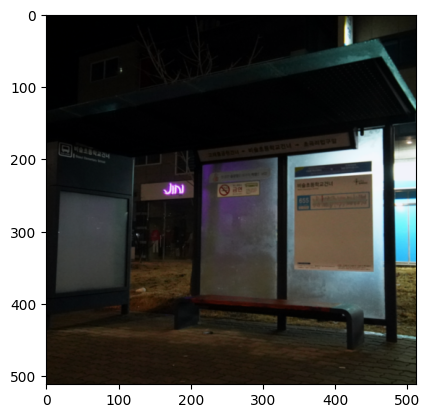

In [81]:
def predict_single(image, label, mask):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction, mask)
predict_single(*val_dataset[1497])

In [82]:
val_dataset.im_path(1497)

'../data/test/blur/clear_gt/real_blur/gt_489.png'

In [39]:
for i, data in enumerate(val_dataset):
    image = data[0]
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    pred_label = decode_target(prediction)
    tar_label = decode_target(data[1])
    if pred_label != tar_label:
        print(i)

6
13
57
63
65
71
77
79
86
101
117
128
129
139
990
991
992
995
1015
1024
1026
1027
1029
1033
1045
1050
1062
1063
1105
1109
1111
1112
1124
1198
1202
1211
1878
2053
2058
2078
2094
2106
2108
2134
2141
2144
2168
2172
2201
2206
2216
2222
2229
2234
2282
2296
2298
2332
2349
2364
2388
2409
2422
2465
2466
2495
2729
2767
2814
2815
2820
2821
2822
2823
2957
2996
3044
3050
3053
3056
3065
3066
3071
3074
3075
3080
3085
3087
3096
3100
3106
3111
3112
3115
3117
3119
3120
3121
3125
3136
3137
3149
3154
3157
3161
3165
3166
3167
3177
3182
3189
3191
3203
3206
3209
3213
3214
3218
3229
3230
3242
3247
3248
3251
3255
3259
3266
3270
3280
3283
3286
3292
3305
3307
3308
3320
3328
3331
3332
3334
3339
3350
3351
3358
3363
3366
3377
3380
3386
3394
3395
3396
3398
3410
3416
3422
3427
3428
3432
3438
3450
3471
3480
3486
3489
3496
3508
3516
3517
3519
3530
3538
3542
3710
4456
4749
4764
4827
4947
4956
4964
4989
5017
5027
5099
5141
5174
5207
5224
5262
5267
5268
5275
5297
5353
5355
5371
5388
5389
5401
5402
5409
5410
5413
5414
541

Label: blur rain
mask: blur

tensor([9.1094e-01, 1.3927e-08, 2.8828e-03, 5.5546e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)


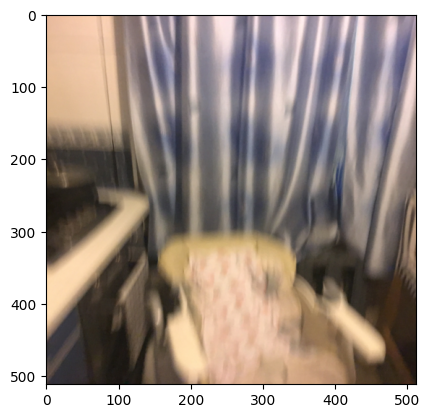

In [139]:
predict_single(*val_dataset[57])

In [140]:
val_dataset.im_path(57)

'../data/test/blur/35_IPHONE-6S_M.jpeg'

Label: clear
mask: blur

tensor([0., 0., 0., 0.])


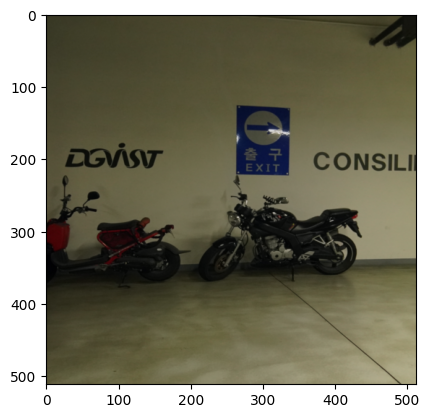

In [60]:
show_example(*val_dataset[1258])

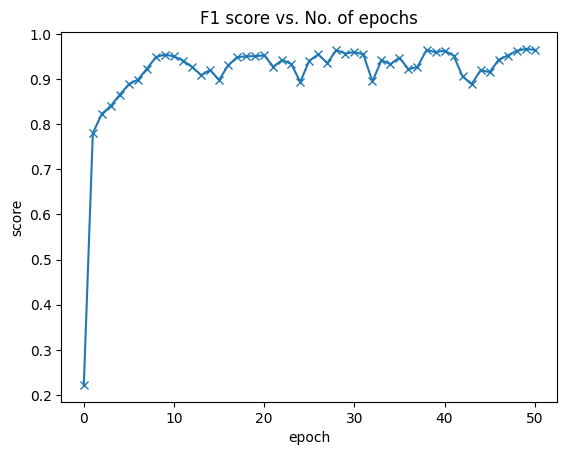

In [61]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

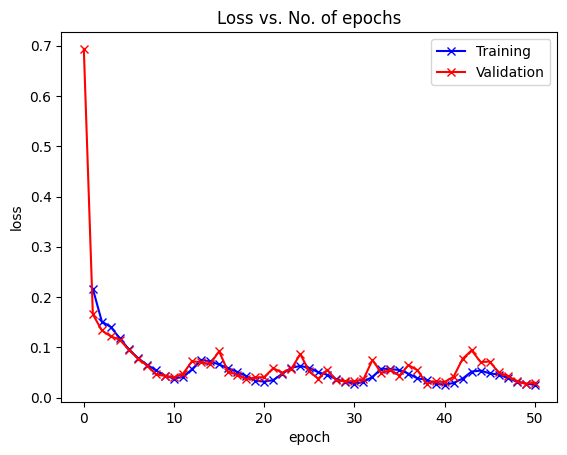

In [62]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

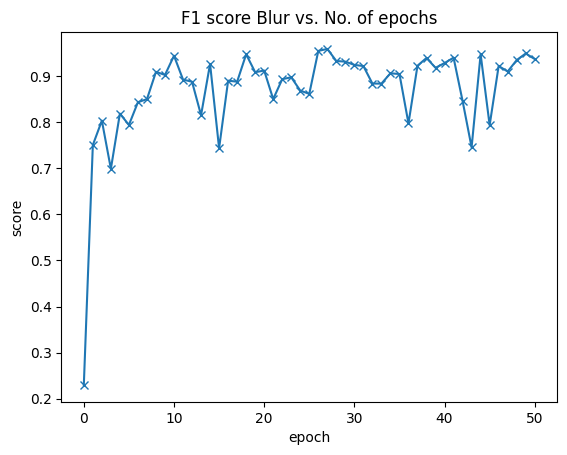

In [63]:
def plot_scores(history):
    scores = [x['val_score_blur'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Blur vs. No. of epochs');
plot_scores(history)

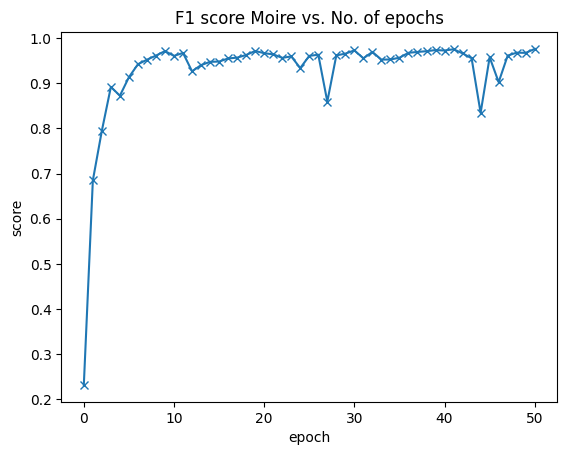

In [64]:
def plot_scores(history):
    scores = [x['val_score_demoir'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Moire vs. No. of epochs');
plot_scores(history)

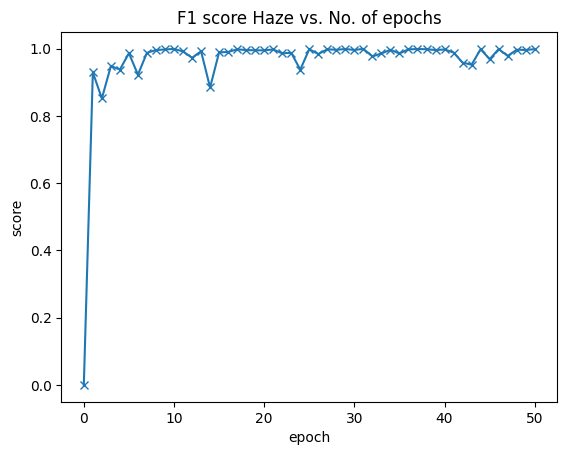

In [65]:
def plot_scores(history):
    scores = [x['val_score_haze'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Haze vs. No. of epochs');
plot_scores(history)

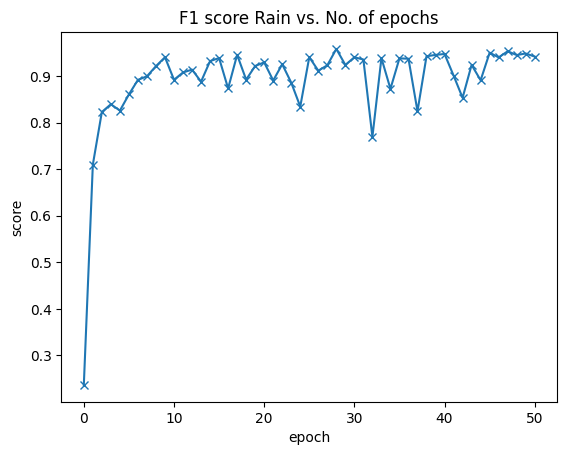

In [66]:
def plot_scores(history):
    scores = [x['val_score_rain'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Rain vs. No. of epochs');
plot_scores(history)

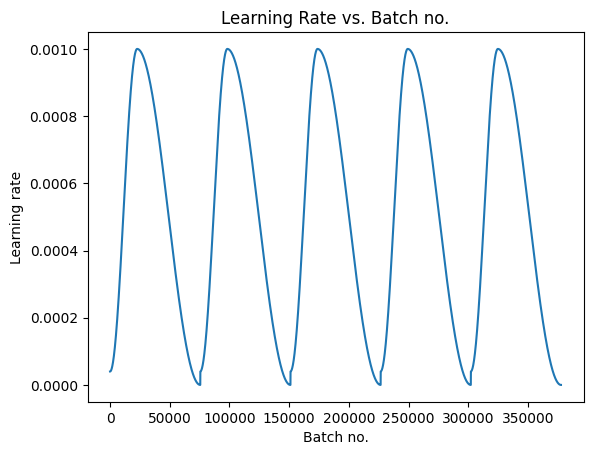

In [67]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [68]:
def random_image_prediction(url): #This function is to see the predictions of random images from internet.
    image_url = requests.get(url, stream = True).raw
    image = Image.open(image_url)
    image_tensor = val_trans(image).unsqueeze(0)
    img = to_device(image_tensor, device)
    preds = model(img)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

Prediction:
Tensor:  tensor([2.7597e-03, 3.5632e-04, 9.8975e-01, 4.6984e-05], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: haze


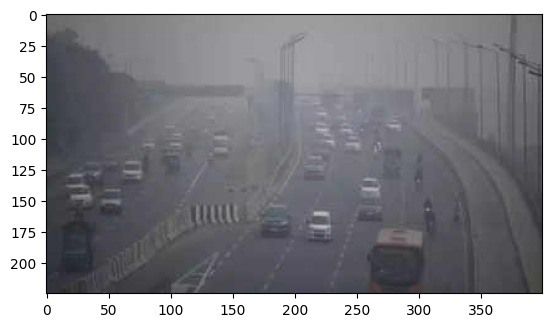

In [80]:
random_image_prediction('https://static.toiimg.com/thumb/msid-88217291,width-400,resizemode-4/88217291.jpg')

Prediction:
Tensor:  tensor([8.4035e-01, 8.0936e-07, 3.1128e-03, 1.0090e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: blur


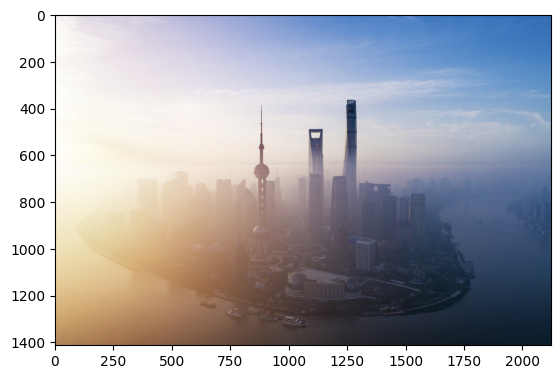

In [70]:
random_image_prediction('https://metro.co.uk/wp-content/uploads/2018/06/gettyimages-682966492.jpg?quality=90&strip=all')

Prediction:
Tensor:  tensor([0.0049, 0.0656, 0.1699, 0.1211], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: clear


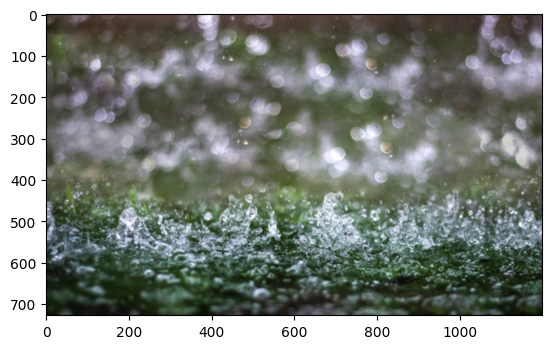

In [79]:
random_image_prediction('https://www.envirostraw.com.au/wp-content/uploads/2022/08/ES-rain-soil-01.jpg')

Label: clear
mask: demoir

tensor([5.5939e-03, 2.9373e-05, 1.3461e-03, 1.1264e-02], device='cuda:0',
       grad_fn=<SelectBackward0>)


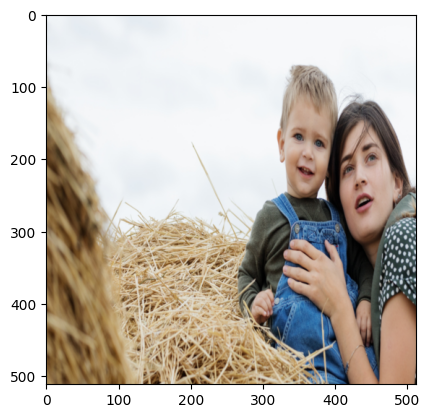

In [77]:
predict_single(*val_dataset[3282]) #checking out the predictions of some images from the validation dataset.

In [78]:
val_dataset.im_path(3282)

'../data/test/demoir/clear_gt/image_312.jpg'

In [55]:
PATH = os.path.join('../saved_models', datetime.now().strftime('mobilevit_frozen_512_full_data_15_05_23.pt'))
torch.save(model.state_dict(), PATH)

In [ ]:
loaded_model = CustomModel().to(device)

In [ ]:
loaded_model.load_state_dict(torch.load('saved_models/mobilenetv2_customBCE_new_metrics_not_pretrained_13_05_23.pt'))

In [ ]:
loaded_model.to(device)

In [ ]:
loaded_model.eval()

### Testing mixed data

In [101]:
val_dataset_mixed = myDataset(_C.VAL_PATH_MIXED, transform = val_trans)

In [102]:
len(val_dataset_mixed)

2023

In [103]:
val_loader_mixed = DataLoader(val_dataset_mixed, _C.BATCH_SIZE * 2, num_workers = 12)

In [104]:
val_dl_mixed = DeviceDataLoader(val_loader_mixed, device)

In [105]:
evaluate(model, val_dl_mixed)

  0%|          | 0/253 [00:00<?, ?it/s]

blur
prec 0.9999999999999987, rec 0.39495798319327713, f2 0.5662650602405574
demoir
prec 0.9977973568281927, rec 0.905999999999999, f2 0.949685534590695
haze
prec 0.0, rec 0.0, f2 0.0
rain
prec 0.9824561403508686, rec 0.10948191593352873, f2 0.19700967458205318


{'val_loss': 1.7590293884277344,
 'val_score': 0.5979924304751183,
 'val_score_blur': 0.5662650602405574,
 'val_score_haze': 0.0,
 'val_score_rain': 0.19700967458205318,
 'val_score_demoir': 0.949685534590695}

Label: demoir
mask: blur demoir

tensor([3.6604e-02, 9.8083e-01, 4.4384e-04, 8.1488e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)


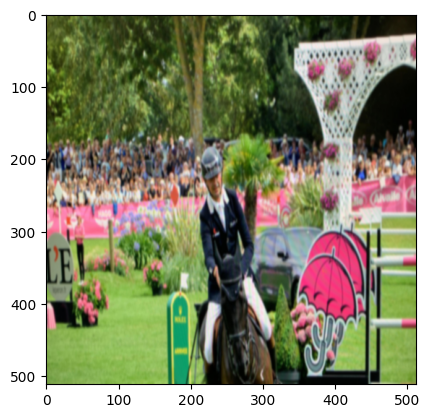

In [162]:
predict_single(*val_dataset_mixed[10])